# Disaster Tweets data analysis

In [121]:
import re
import string
import numpy as np
import pandas as pd
import scipy as sp
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import validators as vld

In [122]:
df_train = pd.read_csv('./train.csv')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [123]:
df_train.sample(n=10)

,id,keyword,location,text,target
2736,3933,devastated,NaN,abcnews - Obama Declares Disaster for Typhoon-...,1
6045,8640,seismic,NaN,#Sismo DETECTADO #JapÌ_n 06:32:43 Miyagi Estim...,1
2811,4043,disaster,USA,DISASTER AVERTED: Police kill gunman with Û÷h...,0
2925,4204,drowned,"Alberta, VA",http://t.co/MoA0q0AuFa Jacksonville family ban...,0
5011,7147,mudslide,"Ealing, London",'It looks like a mudslide!' And #GBBO is back ...,1
1125,1622,bombed,Cape Town,You just got GIF bombed #AfricansInSF #BeyondG...,0
408,588,arson,"Menasha, WI",Arson suspect linked to 30 fires caught in Nor...,1
4916,7001,mayhem,"Orlando, FL",I guess ill never be able to go to mayhem...,0
3590,5128,fatal,"Laredo, TX",Petition to remaster Fatal Frame 1 with a Wind...,0
409,589,arson,NaN,Tennessee lesbian couple faked hate crime and ...,1


In [124]:
df_train.fillna(value={'keyword': '', 'location': ''}, inplace=True)
df_train.sample(n=10)

,id,keyword,location,text,target
5148,7342,nuclear%20reactor,"Bournemouth, Dorset, UK",@SnowyWolf5 @TheGreenParty Besides would you r...,1
1434,2069,casualty,"El Dorado, KS",@ThomasHCrown My grandfather was set to be in ...,1
236,336,annihilated,,@TomcatArts 'who then were annihilated by the ...,0
7446,10657,wounds,"Charlotte, N.C.",Dr. Owen says four of Ferrell's ten bullet wou...,1
6799,9739,tragedy,,Rly tragedy in MP: Some live to recount horror...,1
1779,2554,crash,,I feel that 'crash and burn' by Thomas Rhett f...,0
661,956,blaze,PA,pic of me and blaze in a fort when we were kid...,0
2361,3397,demolition,"California, USA",Seven Chinese Christians Are Detained Amid Wid...,1
3860,5491,flames,Republica Dominicana,Maryland mansion fire that killed 6 caused by ...,1
5230,7476,obliteration,Indiana,Why did God order obliteration of ancient Cana...,0


In [125]:
PUNCTUATION = set(string.punctuation)
STOP_WORDS = set(nltk.corpus.stopwords.words('english'))
LEMM = nltk.WordNetLemmatizer()

def is_not_stopword(word):
    return word not in STOP_WORDS

def is_not_number(token):
    return not token.isdigit()

def is_not_url(token):
    return not vld.url(token)

def remove_punctuation(input):
    return ''.join([c for c in input if c not in PUNCTUATION])

def tokenize(input):
    return nltk.word_tokenize(input.lower())

def clean_text(input):
    tokens = re.split('\\s+', input.lower())
    tokens = filter(is_not_url, tokens)
    tokens = filter(is_not_stopword, tokens)
    tokens = map(remove_punctuation, tokens)
    tokens = filter(is_not_number, tokens)
    tokens = map(LEMM.lemmatize, tokens)
    return ' '.join(tokens)


df_train['clean_text'] = df_train['text'].apply(lambda txt: clean_text(txt))


In [134]:
def move_target_rigth(df):
    target = df['target']
    df = df.drop(['target'], axis=1)
    df['target'] = target
    return df

df_train['tokenized'] = df_train['text'].apply(lambda txt: tokenize(txt))
df_train['text_length'] = df_train['text'].apply(lambda txt: len(txt)-txt.count(' '))
df_train['upper_text_length'] = df_train['text'].apply(lambda txt: sum(1 for c in txt if c.isupper()))
df_train['upper_text_factor'] = df_train['upper_text_length']/df_train['text_length']
df_train['tags_count'] = df_train['text'].apply(lambda txt: sum(1 for c in txt if c=='#'))
df_train['punct_factor'] = df_train['text'].apply(lambda txt: sum(1 for c in txt if c in PUNCTUATION)) / df_train['text_length']
df_train['ann_count'] = df_train['text'].apply(lambda txt: sum(1 for c in txt if c=='@'))
df_train['urls_count'] = df_train['text'].apply(lambda txt: len(list(filter(vld.url, txt.split(' ')))))

df_train['tokens_count'] = df_train['tokenized'].apply(lambda tokens: len(tokens))
df_train['stop_words_count'] = df_train['tokenized'].apply(lambda tokens: sum(1 for token in tokens if token in STOP_WORDS))
df_train['stop_words_factor'] = df_train['stop_words_count'] / df_train['tokens_count']
df_train['clean_tokens_count'] = df_train['tokens_count'] - df_train['stop_words_count']
df_train['clean_tokens_factor'] = df_train['clean_tokens_count'] / df_train['tokens_count']

df_train['missing_location'] = df_train['location'].apply(lambda txt: 0 if txt is np.nan else int(len(txt)==0))

df_train = move_target_rigth(df_train)

df_train.sample(n=10)


,id,keyword,location,text,clean_text,tokenized,text_length,upper_text_length,upper_text_factor,tags_count,punct_factor,ann_count,urls_count,tokens_count,stop_words_count,stop_words_factor,clean_tokens_count,clean_tokens_factor,missing_location,target
4129,5870,hailstorm,"Iliff,Colorado",Severe hailstorm in progress over Northeast Lo...,severe hailstorm progress northeast logan coun...,"[severe, hailstorm, in, progress, over, northe...",79,10,0.126582,1,0.113924,0,1,14,2,0.142857,12,0.857143,0,1
4777,6796,lightning,"Waverly, IA",'When you walk away\nNothing more to say\nSee ...,when walk away nothing say see lightning eye s...,"['when, you, walk, away, nothing, more, to, sa...",89,5,0.056180,0,0.022472,0,0,21,8,0.380952,13,0.619048,0,0
3135,4504,emergency,"New Orleans, LA",Emergency Dispatchers in Boone County in the h...,emergency dispatcher boone county hot seat,"[emergency, dispatchers, in, boone, county, in...",67,7,0.104478,0,0.074627,0,1,12,3,0.250000,9,0.750000,0,0
5421,7737,panicking,,When he lets you drive his truck and you start...,let drive truck start panicking flip bitch,"[when, he, lets, you, drive, his, truck, and, ...",105,5,0.047619,0,0.133333,0,1,29,11,0.379310,18,0.620690,1,0
890,1288,bloody,"England,UK,Europe,Sol 3.",@LauradeHolanda I have the Forrest version fro...,lauradeholanda forrest version thats bloody aw...,"[@, lauradeholanda, i, have, the, forrest, ver...",74,4,0.054054,0,0.094595,1,0,20,6,0.300000,14,0.700000,0,0
436,633,arsonist,snapchat // fvck_casper,@local_arsonist I guess u can say that it's ju...,localarsonist guess u say shit thinking,"[@, local_arsonist, i, guess, u, can, say, tha...",65,2,0.030769,0,0.046154,1,0,17,9,0.529412,8,0.470588,0,0
838,1217,blizzard,,First Time Playing Hearthstone on PC Thoughts ...,first time playing hearthstone pc thought,"[first, time, playing, hearthstone, on, pc, th...",61,11,0.180328,0,0.081967,0,1,10,1,0.100000,9,0.900000,1,0
5782,8251,rioting,,if that would of been a black dude Antioch wou...,would black dude antioch would rioting,"[if, that, would, of, been, a, black, dude, an...",48,1,0.020833,0,0.000000,0,0,12,6,0.500000,6,0.500000,1,0
4899,6974,massacre,Ecuador,Don't mess with my Daddy I can be a massacre. ...,mess daddy massacre becarefulharry,"[do, n't, mess, with, my, daddy, i, can, be, a...",51,6,0.117647,1,0.058824,0,0,14,7,0.500000,7,0.500000,0,0
1324,1915,burning,http://www.amazon.com/dp/B00HR,'CALIFORNIA IS BURNING:' Gov. Jerry Brown told...,california burning gov jerry brown told report...,"['california, is, burning, :, ', gov, ., jerry...",120,28,0.233333,0,0.100000,0,1,23,5,0.217391,18,0.782609,0,1


In [135]:
keywords = df_train['keyword'].unique()
keywords[0:10]

array(['', 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon'], dtype=object)

In [136]:
keywords_count = df_train.groupby(['keyword']).size().reset_index(name='count')
keywords_count

,keyword,count
0,,61
1,ablaze,36
2,accident,35
3,aftershock,34
4,airplane%20accident,35
...,...,...
217,wounded,37
218,wounds,33
219,wreck,37
220,wreckage,39


In [137]:
keywords_count_per_target = df_train.groupby(['keyword', 'target']).size().reset_index(name='count').query('target == 1')
keywords_count_per_target.rename(columns={'count': 'positive_count'}, inplace=True)
keywords_count_per_target

,keyword,target,positive_count
1,,1,42
3,ablaze,1,13
5,accident,1,24
8,airplane%20accident,1,30
10,ambulance,1,20
...,...,...,...
432,wounded,1,26
434,wounds,1,10
436,wreck,1,7
437,wreckage,1,39


In [138]:
keywords_stats = pd.merge(keywords_count, keywords_count_per_target, on='keyword', how='inner')
keywords_stats

,keyword,count,target,positive_count
0,,61,1,42
1,ablaze,36,1,13
2,accident,35,1,24
3,airplane%20accident,35,1,30
4,ambulance,38,1,20
...,...,...,...,...
216,wounded,37,1,26
217,wounds,33,1,10
218,wreck,37,1,7
219,wreckage,39,1,39


In [139]:
keywords_stats['positive_factor'] = keywords_stats['positive_count'] / keywords_stats['count']
keywords_stats.drop(['count', 'target', 'positive_count'], axis=1, inplace=True)
keywords_stats

,keyword,positive_factor
0,,0.688525
1,ablaze,0.361111
2,accident,0.685714
3,airplane%20accident,0.857143
4,ambulance,0.526316
...,...,...
216,wounded,0.702703
217,wounds,0.303030
218,wreck,0.189189
219,wreckage,1.000000


In [140]:
df_train_new = pd.merge(df_train, keywords_stats, on='keyword', how='inner')

In [141]:
df_train_new.sample(n=10)

,id,keyword,location,text,clean_text,tokenized,text_length,upper_text_length,upper_text_factor,tags_count,...,ann_count,urls_count,tokens_count,stop_words_count,stop_words_factor,clean_tokens_count,clean_tokens_factor,missing_location,target,positive_factor
993,1491,body%20bags,"LONG ISLAND, NY",BODY BAGS! https://t.co/0McXc68GZD,body bag,"[body, bags, !, https, :, //t.co/0mcxc68gzd]",32,13,0.406250,0,...,0,1,6,0,0.000000,6,1.000000,0,0,0.024390
7170,10320,weapon,www.twitch.tv/PKSparkxx,Slosher is GOAT. Freaking love that weapon. Ca...,slosher goat freaking love weapon cant wait ep...,"[slosher, is, goat, ., freaking, love, that, w...",109,11,0.100917,0,...,0,0,28,11,0.392857,17,0.607143,0,0,0.358974
3628,5212,fatality,playing soccer & eating pizza,@Jake_ADavis @FaTality_US we are cuddling righ...,jakeadavis fatalityus cuddling right so,"[@, jake_adavis, @, fatality_us, we, are, cudd...",51,7,0.137255,0,...,2,0,13,4,0.307692,9,0.692308,0,0,0.270270
1084,1613,bombed,,@r_lauren83199 @xojademarie124 i hope you get ...,rlauren83199 xojademarie124 hope get batista b...,"[@, r_lauren83199, @, xojademarie124, i, hope,...",59,2,0.033898,0,...,2,0,11,2,0.181818,9,0.818182,1,0,0.500000
7358,10578,windstorm,"Sugar Land, TX",Texas Seeks Comment on Rules for Changes to Wi...,texas seek comment rule change windstorm insur...,"[texas, seeks, comment, on, rules, for, change...",86,11,0.127907,0,...,1,1,16,3,0.187500,13,0.812500,0,0,0.400000
5503,7898,radiation%20emergency,,WIPP emergency activated because of slightly e...,wipp emergency activated slightly elevated lev...,"[wipp, emergency, activated, because, of, slig...",72,4,0.055556,1,...,0,0,13,3,0.230769,10,0.769231,1,1,0.555556
6981,10056,twister,london,Am now repped by the fantastic Laura Milne @Th...,repped fantastic laura milne thejonesesvoice l...,"[am, now, repped, by, the, fantastic, laura, m...",108,7,0.064815,0,...,1,0,23,10,0.434783,13,0.565217,0,0,0.125000
4268,6109,hellfire,"Denver, Colorado",the message you sent and they don't reply. I s...,message sent reply see saw message least tell ...,"[the, message, you, sent, and, they, do, n't, ...",105,1,0.009524,0,...,0,0,32,18,0.562500,14,0.437500,0,0,0.179487
1031,1537,bomb,travelling to tae's pants,namjoon's FANTASTIC IS BOMB BYE OMG,namjoons fantastic bomb bye omg,"[namjoon, 's, fantastic, is, bomb, bye, omg]",30,21,0.700000,0,...,0,0,7,1,0.142857,6,0.857143,0,0,0.441176
655,993,blazing,Between the worlds,I'm the only weapons master here! Let's go in ...,im weapon master here let go gun blazing hinat...,"[i, 'm, the, only, weapons, master, here, !, l...",60,3,0.050000,1,...,0,0,17,5,0.294118,12,0.705882,0,0,0.029412


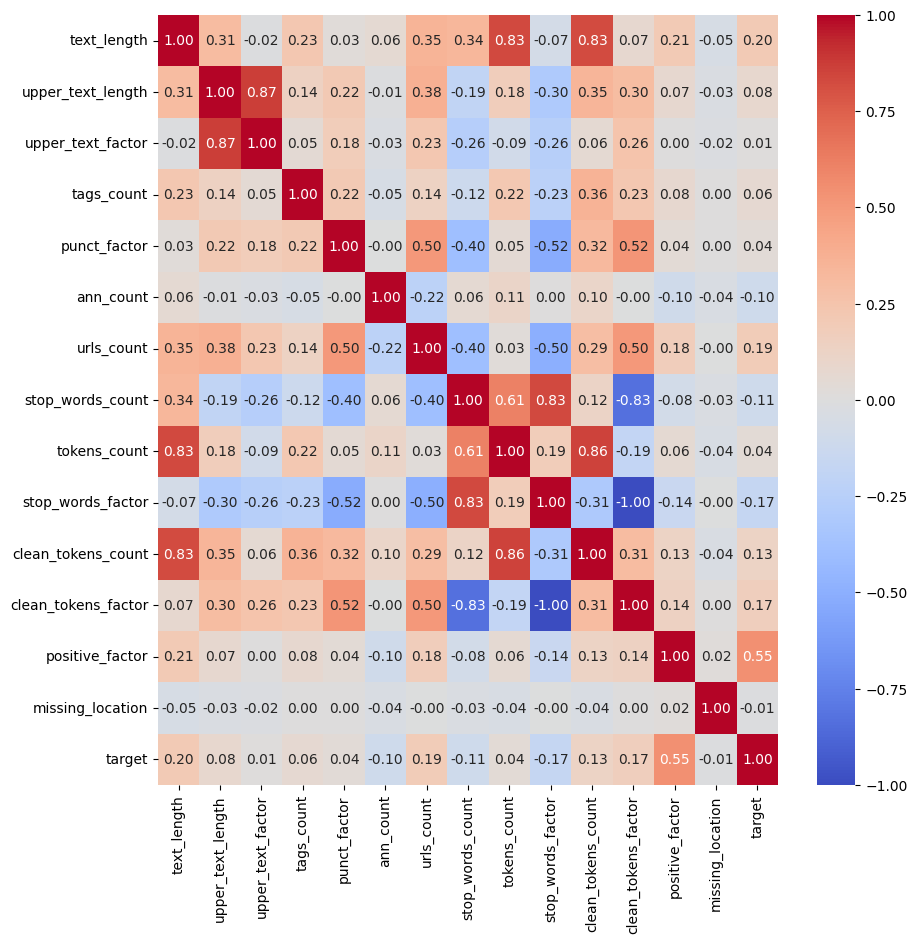

In [142]:
selected_features = ['text_length','upper_text_length', 'upper_text_factor', 'tags_count', 'punct_factor', 'ann_count', 'urls_count',
                     'stop_words_count', 'tokens_count', 'stop_words_factor', 'clean_tokens_count', 'clean_tokens_factor', 'positive_factor',
                     'missing_location',
                     'target']
df_corr = df_train_new[selected_features].corr()

plt.figure(figsize=(10, 10))
sns.heatmap(df_corr, annot=True, fmt=".2f", cmap='coolwarm', 
            xticklabels=df_corr.columns, yticklabels=df_corr.columns)
plt.show()

In [108]:
save_features = ['id', 'keyword', 'location', 'text', 
                 'clean_text', 
                 'text_length', 'upper_text_factor', 'tags_count', 'punct_factor', 'ann_count', 'urls_count',
                 'stop_words_factor', 'clean_tokens_factor', 
                 'positive_factor',
                 'target']

df_train_new[save_features].to_csv('./train_preprocessed.csv')